### Load libraries and functions

In [1]:

import sys
sys.path.insert(0, '../src/')

from loopless_utils import loops_enumeration_from_fva

from load_modify_sample_utils import load_model, get_objective_functions, get_reaction_bounds, modify_model
from load_modify_sample_utils import sample_optgp

from correlations_utils import correlated_reactions, split_forward_reverse, find_reactants_products

from clustering_utils import clustering_of_correlation_matrix, plot_dendrogram

from pathways_utils import dictionary_reaction_id_to_kegg_id, get_kegg_pathways_from_reaction_ids
from pathways_utils import map_model_to_kegg_reactions_dictionary, read_json_file, fill_missing_kegg_ids_in_initial_dictionary
from pathways_utils import subset_model_reactions_from_pathway_info, subset_sampling_array_from_reaction_ids, sort_reactions_by_model_order
from pathways_utils import dictionary_reaction_id_to_pathway, dictionary_map_reverse_reaction_id_to_pathway


### Load and inspect model (for more info see `load_modify_samply.ipynb`)

In [3]:

ec_cobra_model, ec_cobra_reactions, ec_cobra_reaction_ids,  = load_model("../ext_data/models/e_coli_core.xml")

objective_functions = get_objective_functions(ec_cobra_model)
print(objective_functions)

default_reaction_bounds = get_reaction_bounds(ec_cobra_model)
print(default_reaction_bounds.get("BIOMASS_Ecoli_core_w_GAM"))


Set parameter Username
Set parameter LicenseID to value 2642044
Academic license - for non-commercial use only - expires 2026-03-25
['BIOMASS_Ecoli_core_w_GAM']
(0.0, 1000.0)


### Modify the model to create two different conditions (for more info see `load_modify_samply.ipynb`)

In [4]:

# Set optimal percentage to 100
ec_cobra_model_condition_100 = modify_model(
    cobra_model         = ec_cobra_model,
    objective_function  = "BIOMASS_Ecoli_core_w_GAM",
    optimal_percentage  = 100,
    objective_direction = "max"
)

updated_objective_functions = get_objective_functions(ec_cobra_model_condition_100)
print(updated_objective_functions)

updated_reaction_bounds = get_reaction_bounds(ec_cobra_model_condition_100)
print(updated_reaction_bounds.get("BIOMASS_Ecoli_core_w_GAM"))

# -----------

# Set optimal percentage to 0
ec_cobra_model_condition_0 = modify_model(
    cobra_model         = ec_cobra_model,
    objective_function  = "BIOMASS_Ecoli_core_w_GAM",
    optimal_percentage  = 0,
    objective_direction = "max"
)

updated_objective_functions = get_objective_functions(ec_cobra_model_condition_0)
print(updated_objective_functions)

updated_reaction_bounds = get_reaction_bounds(ec_cobra_model_condition_0)
print(updated_reaction_bounds.get("BIOMASS_Ecoli_core_w_GAM"))


Read LP format model from file /tmp/tmpydbawlc2.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros


['BIOMASS_Ecoli_core_w_GAM']
(0.872922, 1000)
Read LP format model from file /tmp/tmpfc8ee7_1.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
['BIOMASS_Ecoli_core_w_GAM']
(0.0, 1000)


### Identify loopy reactions in model (for more info see `loopless.ipynb`)

In [4]:

loopy_reactions_fva_100 = loops_enumeration_from_fva(ec_cobra_model_condition_100, fraction_of_optimum=0.999)
print(loopy_reactions_fva_100)

loopy_reactions_100 = [item[0] for item in loopy_reactions_fva_100]
print(loopy_reactions_100)


loopy_reactions_fva_0 = loops_enumeration_from_fva(ec_cobra_model_condition_0, fraction_of_optimum=0)
print(loopy_reactions_fva_0)

loopy_reactions_0 = [item[0] for item in loopy_reactions_fva_0]
print(loopy_reactions_0)


[('SUCDi', 994.7794007141792), ('FRD7', 995.0539767141795)]
['SUCDi', 'FRD7']
[('SUCDi', 980.0), ('FRD7', 1000.0)]
['SUCDi', 'FRD7']


### Remove loopy reactions from the 2 models created above to reduce the thermodynamically infeasible solutions from sampling

In [4]:

ec_cobra_model_condition_100.reactions.get_by_id("FRD7").bounds = (0, 0)
ec_cobra_model_condition_0.reactions.get_by_id("FRD7").bounds = (0, 0)


### Perform sampling on the modified models with the loopy reaction "FRD7" removed. (for more info see `load_modify_samply.ipynb`)

In [5]:

samples_optgp_condition_100 = sample_optgp(ec_cobra_model_condition_100, 
                                           n_samples = 3000, 
                                           thinning=100, 
                                           reaction_in_rows = True)

samples_optgp_condition_0 = sample_optgp(ec_cobra_model_condition_0, 
                                         n_samples = 3000, 
                                         thinning=100, 
                                         reaction_in_rows = True)


Read LP format model from file /tmp/tmp_kd6nyhj.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros


Read LP format model from file /tmp/tmp_tl4ky69.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros


### Map KEGG pathway information to reactions BiGG ids

Functions that are used to map information from KEGG pathways to the model reactions (BiGG/SEED ids). For more info see `pathways.ipynb`

In [5]:

initial_bigg_to_kegg_dictionary = map_model_to_kegg_reactions_dictionary(ec_cobra_model)

reactions_json, reactions_pandas = read_json_file("../ext_data/reactions/reactions.json")

bigg_to_kegg, seed_to_kegg = dictionary_reaction_id_to_kegg_id(reactions_pandas)

final_bigg_to_kegg_dictionary = fill_missing_kegg_ids_in_initial_dictionary(initial_bigg_to_kegg_dictionary, 
                                                                            modeltype="BiGG", 
                                                                            bigg_to_kegg=bigg_to_kegg,
                                                                            seed_to_kegg=seed_to_kegg)

df_kegg_pathways = get_kegg_pathways_from_reaction_ids(final_bigg_to_kegg_dictionary)


### From now on to better illustrate functions related to clustering, we will focus only in certain subsystems of the model (selected pathways of interest). 

We will subset the sampling array to include only reactions from Glycolysis, Glyconeogenesis and the Pentose phosphate pathway. For more information on how these functions works see: `load_modify_samply.ipynb`

In [7]:

Glycolysis = subset_model_reactions_from_pathway_info(df_kegg_pathways, "Glycolysis / Gluconeogenesis")
PPP = subset_model_reactions_from_pathway_info(df_kegg_pathways, "Pentose phosphate pathway")

reactions_in_pathways_ordered_duplicates = sort_reactions_by_model_order(ec_cobra_reaction_ids, Glycolysis, PPP)


# Remove duplicates
reactions_in_pathways_ordered = []
[reactions_in_pathways_ordered.append(val) for val in reactions_in_pathways_ordered_duplicates if val not in reactions_in_pathways_ordered]


subset_pathways_optgp_condition_100 = subset_sampling_array_from_reaction_ids(
                                                                samples_optgp_condition_100, 
                                                                ec_cobra_reaction_ids, 
                                                                subset_reactions = reactions_in_pathways_ordered)


subset_pathways_optgp_condition_0 = subset_sampling_array_from_reaction_ids(
                                                                samples_optgp_condition_0, 
                                                                ec_cobra_reaction_ids, 
                                                                subset_reactions = reactions_in_pathways_ordered)


### Split bidirectional-reversible reactions (having both positive and negative flux values) into two separate reactions (forward and reverse). For more info see: `correlations.ipynb`


In [8]:

(subset_extended_steady_states_100,
 subset_extended_reactions_100) = split_forward_reverse(subset_pathways_optgp_condition_100, 
                                                        reactions=reactions_in_pathways_ordered)

(reversibility_list_all_reactions_100, 
 reactants_list_all_reactions_100,
 products_list_all_reactions_100) = find_reactants_products(ec_cobra_model, 
                                                            subset_extended_reactions_100)

print(len(reversibility_list_all_reactions_100), len(reactants_list_all_reactions_100))



(subset_extended_steady_states_0,
 subset_extended_reactions_0) = split_forward_reverse(subset_pathways_optgp_condition_0,
                                               reactions=reactions_in_pathways_ordered)

(reversibility_list_all_reactions_0,
 reactants_list_all_reactions_0,
 products_list_all_reactions_0) = find_reactants_products(ec_cobra_model, 
                                                          subset_extended_reactions_0)
 
print(len(reversibility_list_all_reactions_0), len(reactants_list_all_reactions_0))


21 21
25 25


### Calculate pairwise linear correlations and non-linear copula dependencies without filtering for sharing metabolites. For more info see: `correlations.ipynb`

In [9]:

(subset_linear_correlation_matrix_100, 
subset_non_linear_correlation_matrix_100, 
subset_mixed_correlation_matrix_100, 
subset_correlations_dictionary_100) = correlated_reactions(
        steady_states = subset_extended_steady_states_100,
        boolean_sharing_metabolites_matrix=None,
        reactions=subset_extended_reactions_100,
        linear_coeff = "pearson",
        linear_corr_cutoff = 0.3, 
        indicator_cutoff = 1.2,
        jensenshannon_cutoff = 0.05,
        std_cutoff= 1e-2,
        include_non_linear = True, 
        cells = 5, 
        cop_coeff = 0.2, 
        lower_triangle = False, 
        verbose = True
)


(subset_linear_correlation_matrix_0, 
subset_non_linear_correlation_matrix_0, 
subset_mixed_correlation_matrix_0, 
subset_correlations_dictionary_0) = correlated_reactions(
        steady_states = subset_extended_steady_states_0,
        boolean_sharing_metabolites_matrix=None,
        reactions=subset_extended_reactions_0,
        linear_coeff = "pearson",
        linear_corr_cutoff = 0.3, 
        indicator_cutoff = 1.2,
        jensenshannon_cutoff = 0.05,
        std_cutoff= 1e-2,
        include_non_linear = True, 
        cells = 5, 
        cop_coeff = 0.2, 
        lower_triangle = False, 
        verbose = True
)


Completed the process of 30 from 89 copulas
Completed the process of 1 from 144 copulas
Completed the process of 2 from 144 copulas
Completed the process of 3 from 144 copulas
Completed the process of 4 from 144 copulas
Completed the process of 5 from 144 copulas
Completed the process of 6 from 144 copulas
Completed the process of 7 from 144 copulas
Completed the process of 8 from 144 copulas
Completed the process of 9 from 144 copulas
Completed the process of 10 from 144 copulas
Completed the process of 11 from 144 copulas
Completed the process of 12 from 144 copulas
Completed the process of 13 from 144 copulas
Completed the process of 14 from 144 copulas
Completed the process of 15 from 144 copulas
Completed the process of 16 from 144 copulas
Completed the process of 17 from 144 copulas
Completed the process of 18 from 144 copulas
Completed the process of 19 from 144 copulas
Completed the process of 20 from 144 copulas
Completed the process of 21 from 144 copulas
Completed the proces

### Create a dictionary that maps reaction ids to pathways from KEGG information and also create 2 dictionaries (one for each condition of the full network) additionally including the mapping of the reverse reactions.

The `dictionary_reaction_id_to_pathway` function takes one or multiple lists containing reaction IDs (corresponding to KEGG pathways and creates a dictionary that maps the IDs to pathway names. If a reaction appears in more than 1 pathway, it is classified with the term "Multiple-Pathways"

The `dictionary_map_reverse_reaction_id_to_pathway` function is used when we split bidirectional reactions to separate forward and reverse reactions. It maps the reverse reaction to the corresponding pathway (the one that the forward reactions maps to). It enriches the dictionary created from the `dictionary_reaction_id_to_pathway` function.

In [ ]:

Glycolysis = subset_model_reactions_from_pathway_info(df_kegg_pathways, "Glycolysis / Gluconeogenesis")
PPP = subset_model_reactions_from_pathway_info(df_kegg_pathways, "Pentose phosphate pathway")

bigg_to_pathway_dict = dictionary_reaction_id_to_pathway(Glycolysis = Glycolysis, PPP = PPP)

group_map_100 = dictionary_map_reverse_reaction_id_to_pathway(bigg_to_pathway_dict, subset_extended_reactions_100)
group_map_0 = dictionary_map_reverse_reaction_id_to_pathway(bigg_to_pathway_dict, subset_extended_reactions_0)


### Perform hierarchical clustering of the correlation matrix and plot the produced dendrogram.

The `clustering_of_correlation_matrix` function performs hierarchical clustering of the correlation matrix. It returns the `dissimilarity_matrix` calculated from the given correlation matrix, integer `labels` corresponding to clusters and the `clusters` list which is a nested list containing reaction IDs grouped based on their cluster labels

The `plot_dendrogram` function plots the dendrogram from hierarchical clustering


In [11]:

(dissimilarity_matrix_100,
labels_100,
clusters_100) = clustering_of_correlation_matrix(subset_mixed_correlation_matrix_100, 
                                                reactions=subset_extended_reactions_100, 
                                                linkage="ward", 
                                                t = 1.0, 
                                                correction=False)

plot_dendrogram(dissimilarity_matrix_100, 
                subset_extended_reactions_100, 
                show_labels = True, 
                t = 5, 
                linkage = "ward", 
                group_map=group_map_100,
                label_fontsize = 8)



(dissimilarity_matrix_0,
labels_0,
clusters_0) = clustering_of_correlation_matrix(subset_mixed_correlation_matrix_0, 
                                                reactions=subset_extended_reactions_0, 
                                                linkage="ward", 
                                                t = 1.0, 
                                                correction=False)

plot_dendrogram(dissimilarity_matrix_0, 
                subset_extended_reactions_0, 
                show_labels = True, 
                t = 5, 
                linkage = "ward", 
                group_map=group_map_0,
                label_fontsize = 9)


/home/touliopoulos/project/erasmus/erasmus_2025_project/tests/../src/clustering_utils.py:66: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = hierarchy.linkage(dissimilarity_matrix, linkage)
/home/touliopoulos/project/erasmus/erasmus_2025_project/tests/../src/clustering_utils.py:114: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = hierarchy.linkage(dissimilarity_matrix, method=linkage)


/home/touliopoulos/project/erasmus/erasmus_2025_project/tests/../src/clustering_utils.py:66: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix

/home/touliopoulos/project/erasmus/erasmus_2025_project/tests/../src/clustering_utils.py:114: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



### Benchmark clustering methods. 

In the `clustering_of_correlation_matrix` function we have implemented only the hierarchical (Agglomerative) clustering of the correlation matrix. However, other powerful clustering algorithms exist and we encourage users to test the different methods and decide which they are going to use.

First, we start with the elbow method to find the ideal number of clusters, as some of the clustering algorithms used below use this as a parameter.

Here, we can see that `n_clusers` = 3, seems to produce better results

/home/touliopoulos/miniconda3/envs/dingo-stats-3-10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/touliopoulos/miniconda3/envs/dingo-stats-3-10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/touliopoulos/miniconda3/envs/dingo-stats-3-10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/touliopoulos/miniconda3/envs/dingo-stats-3-10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` 

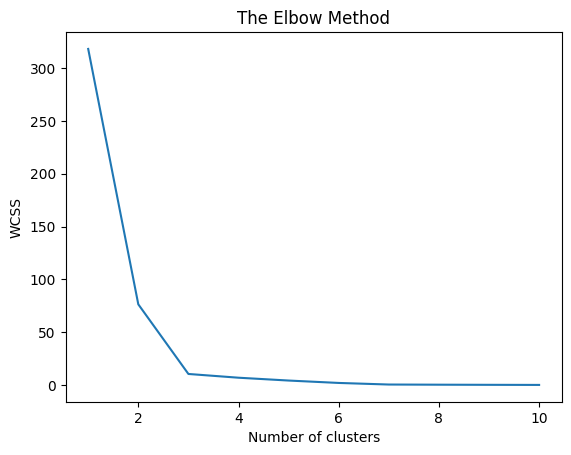

In [19]:

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


X = subset_mixed_correlation_matrix_0.copy()

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    

plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


### Benchmark across KMeans, AgglomerativeClustering, DBSCAN, HDBSCAN and SpectralClustering clustering methods with the Silhouette, Calinski-Harabasz and Davies-Bouldin scores.

Here, we benchmark across these clustering methods and provide some metrics to give insights on clustering quality:
- `Silhouette` Score: Scores closer to 1 are better
- `Calinski-Harabasz` Score: Higher scores are better
- `Davies-Bouldin` Score: Lower scores are better

In [20]:

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
import hdbscan
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import squareform
import numpy as np

X = subset_mixed_correlation_matrix_0.copy()

# Number of clusters
n_clusters = 3


# KMeans
kmeans_labels = KMeans(n_clusters=n_clusters, random_state=42).fit_predict(X)

# Agglomerative (sklearn)
agg_labels = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='average').fit_predict(X)

dbscan = DBSCAN(eps=0.5, min_samples=n_clusters)
dbscan_labels = dbscan.fit_predict(X)

hdb = hdbscan.HDBSCAN(min_cluster_size=n_clusters)
hdbscan_labels = hdb.fit_predict(X)

spectral_labels = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42).fit_predict(X)

# Hierarchical (scipy) same as AgglomerativeClustering
#Z = hierarchy.linkage(dissimilarity, method='average')  # You can change method to 'ward', 'single', etc.
#hier_labels = hierarchy.fcluster(Z, t=n_clusters, criterion='maxclust')


clusterings = {}

clusterings["KMeans"] = kmeans_labels
clusterings["Agglomerative"] = agg_labels
clusterings["DBSCAN"] = dbscan_labels
clusterings["HDBSCAN"] = hdbscan_labels
clusterings["Spectral"] = spectral_labels


def evaluate(X, labels, name):
    labels = np.array(labels)
    if len(np.unique(labels)) < 2 or np.all(labels == -1):
        print(f"\n{name}: Not enough clusters to evaluate.")
        return
    
    print(f"\n{name} Evaluation:")
    
    # Scores closer to 1 are better
    print(f"Silhouette Score:        {silhouette_score(X, labels):.4f}")
    # Higher scores are better
    print(f"Calinski-Harabasz Score: {calinski_harabasz_score(X, labels):.4f}")
    # Lower scores are better
    print(f"Davies-Bouldin Score:    {davies_bouldin_score(X, labels):.4f}")


for name, labels in clusterings.items():
    evaluate(X, labels, name)
    


/home/touliopoulos/miniconda3/envs/dingo-stats-3-10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/touliopoulos/miniconda3/envs/dingo-stats-3-10/lib/python3.10/site-packages/sklearn/cluster/_spectral.py:717: UserWarning:

The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.




KMeans Evaluation:
Silhouette Score:        0.8567
Calinski-Harabasz Score: 321.7593
Davies-Bouldin Score:    0.3168

Agglomerative Evaluation:
Silhouette Score:        0.8567
Calinski-Harabasz Score: 321.7593
Davies-Bouldin Score:    0.3168

DBSCAN Evaluation:
Silhouette Score:        0.8567
Calinski-Harabasz Score: 321.7593
Davies-Bouldin Score:    0.3168

HDBSCAN Evaluation:
Silhouette Score:        0.7811
Calinski-Harabasz Score: 207.2086
Davies-Bouldin Score:    0.3169

Spectral Evaluation:
Silhouette Score:        0.8567
Calinski-Harabasz Score: 321.7593
Davies-Bouldin Score:    0.3168


### Use PCA and tSNE to reduce the dimensions of the correlation matrix

In [21]:

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

X_tsne = TSNE(n_components=2, perplexity=3, random_state=42).fit_transform(X)


def plot_clusters(embedding, labels, title, ax):
    labels = np.array(labels)
    unique_labels = np.unique(labels)
    for lab in unique_labels:
        mask = labels == lab
        ax.scatter(embedding[mask, 0], embedding[mask, 1], label=f"Cluster {lab}", s=80)
    ax.set_title(title)
    ax.legend()



### Plot the first 2 PCA dimensions with data points coloured based on different clustering methhods results 

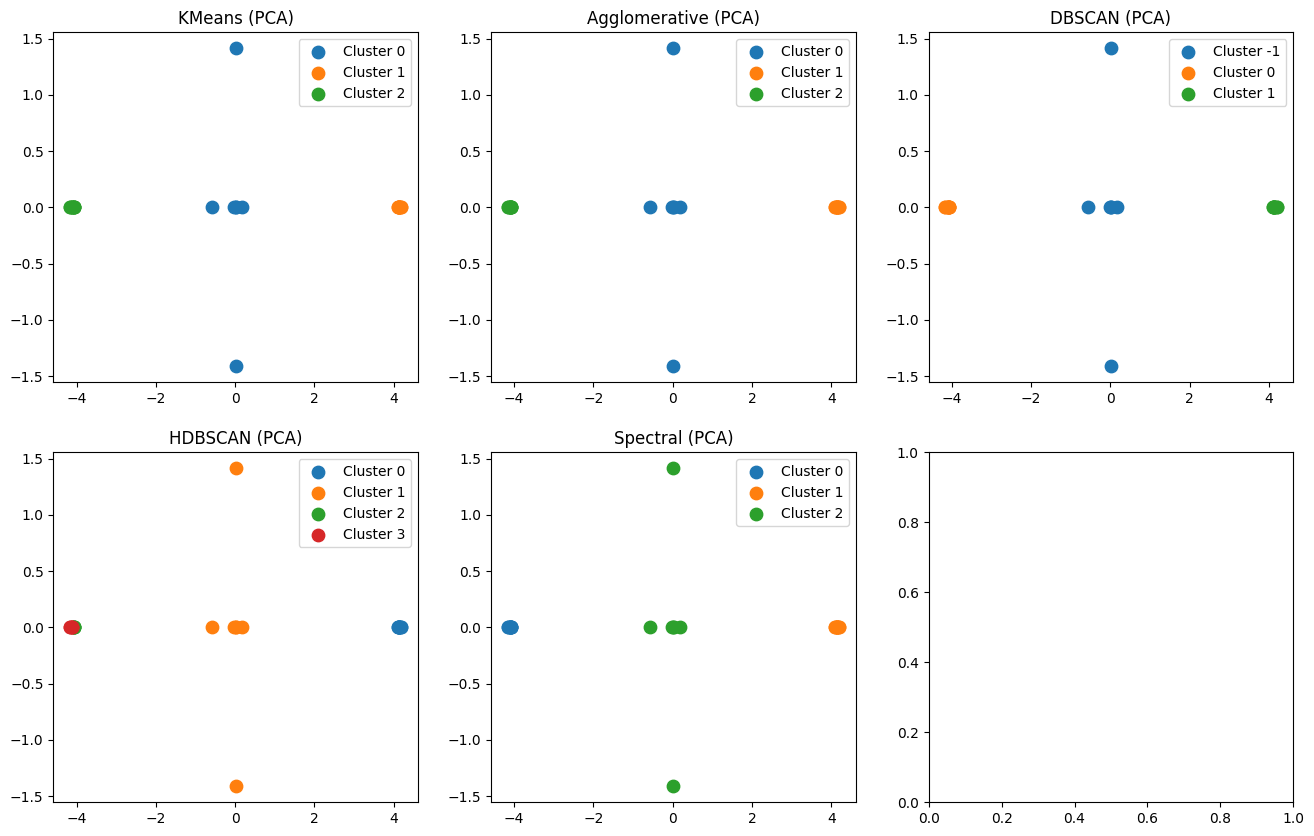

In [22]:

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for i, (name, labels) in enumerate(clusterings.items()):
    plot_clusters(X_pca, labels, f"{name} (PCA)", axes[i])

plt.show()


### Plot the first 2 tSNE dimensions with data points coloured based on different clustering methhods results 

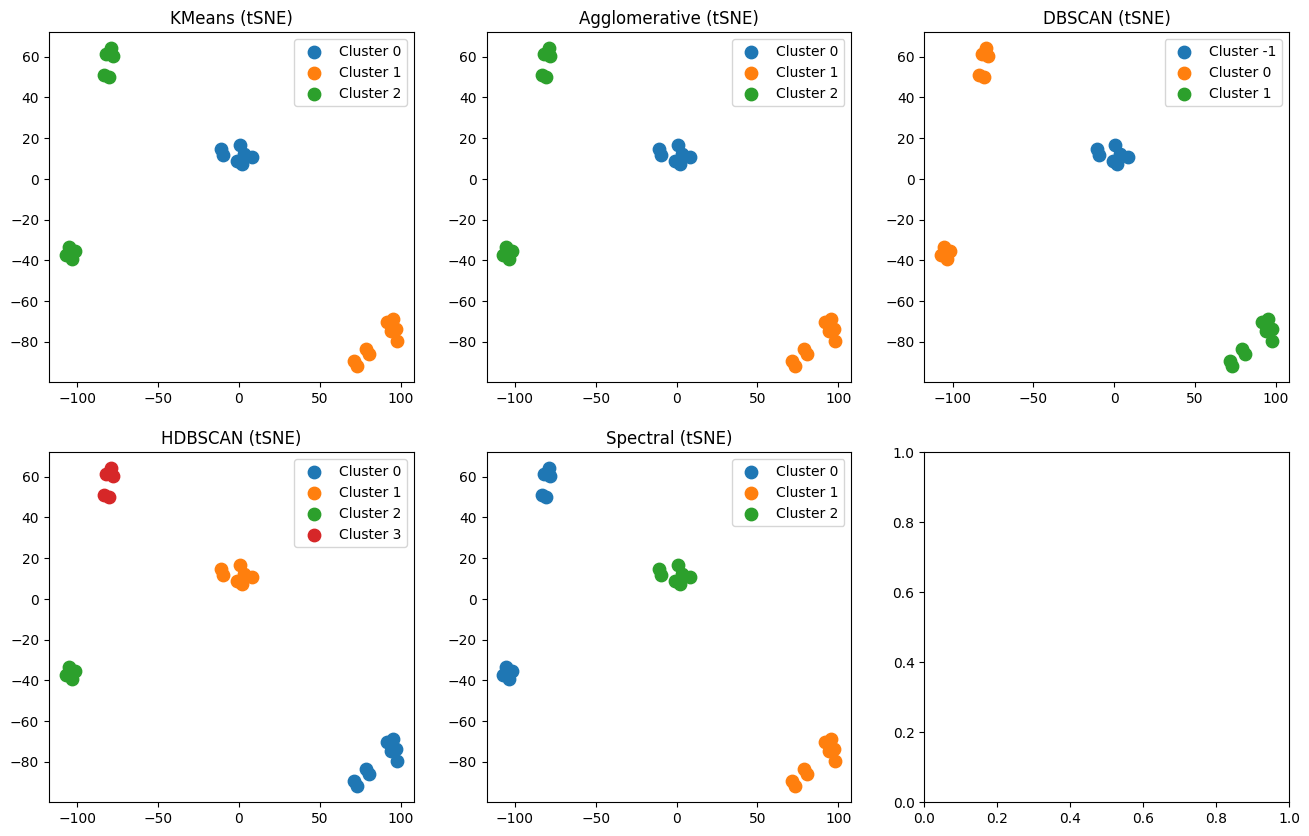

In [23]:

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for i, (name, labels) in enumerate(clusterings.items()):
    plot_clusters(X_tsne, labels, f"{name} (tSNE)", axes[i])

plt.show()
